Forested Protected Lands
===

This notebook overlays the DRWI protected lands and WeConservePA protected lands with the 2019 NLCD land use data using the ModelMyWatershed api. 

The goal of this notebook is to identify whether protected lands overlap with forested areas.

# Setup

## Imports

In [1]:
# Import packages
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from modelmw_client import *
from shapely.validation import make_valid


# Plotting packages
import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.colors import LogNorm
import contextily as ctx
import colorcet as cc
from colorcet.plotting import swatch, swatches, sine_combs
import holoviews as hv

In [2]:
# Look at swatches
# hv.extension("matplotlib")
#swatches()

# CET_D3, CET_CBTL4, diverging_gkr_60_10_c40

In [3]:
# If kernel has not been restarted, restart before running this cell
# Confirm that this repo is in your Python Path
!conda-develop "/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/src"

path exists, skipping C:\Users\clulay\OneDrive - LimnoTech\Documents\GitHub\pollution-assessment\src
completed operation for: C:\Users\clulay\OneDrive - LimnoTech\Documents\GitHub\pollution-assessment\src


In [4]:
# Import PA custom functions
import pollution_assessment as pa
from pollution_assessment import calc, plot_cc, plot

## File paths

In [3]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/stage2/Protected_Lands')

In [4]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent.parent
project_path

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment')

In [8]:
# Path to WeConservePA protected lands shapefile
wcpa_path = project_path / Path('stage2/Protected_Lands/WeConservePA_Shapefile/WeConservePA_pl_20220810.shp')
wcpa_path.exists()

True

## Private file paths
- Download from https://drive.google.com/drive/folders/1HKlnA3lC2xvKBQ1bg1J08gsEB3N9rp2V
- Save in `stage2/private` folder

In [6]:
# Path to FieldDoc protected lands export file
fielddoc_path = project_path / Path('stage2/private/protection_bmps_from_FieldDoc.parquet')
fielddoc_path.exists()

True

# Load data

## Protected Lands from WeConservePA

In [9]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_file(wcpa_path)

In [10]:
# Add data source tag
wcpa_gdf['data_source'] = 'weconservePA_2022'

## Protected Lands from FieldDoc

In [11]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet(fielddoc_path)

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'

fielddoc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   practice_name  75 non-null     object  
 1   practice_id    75 non-null     int64   
 2   program_name   75 non-null     object  
 3   program_id     75 non-null     int64   
 4   organization   75 non-null     object  
 5   description    26 non-null     object  
 6   practice_type  75 non-null     object  
 7   created_at     75 non-null     object  
 8   modified_at    75 non-null     object  
 9   tot_pwr        75 non-null     float64 
 10  head_pwr       75 non-null     float64 
 11  nat_land       75 non-null     float64 
 12  ara_pwr        75 non-null     float64 
 13  wet_pwr        75 non-null     float64 
 14  dev_land       75 non-null     float64 
 15  ag_land        75 non-null     float64 
 16  str_bank       75 non-null     float64 
 17  geometry       75 non-null   

## DRWI Geographies

In [12]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet(project_path / Path('stage1/data/cluster_df.parquet'))  
focusarea_gdf = gpd.read_parquet(project_path / Path('stage1/data/fa_phase2_df.parquet'))

focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

## HUC 8 & 12

In [13]:
huc12_gdf = gpd.read_parquet(project_path / Path('stage2/data_output/huc12_0204.parquet'))
huc08_gdf = gpd.read_parquet(project_path / Path('stage2/data_output/huc08_0204.parquet'))

# Plotting FXNS Carried Over from PlottingFunctions.py

Could not get these to import from the actual .py file, so the necessary functions are copied in below.

In [14]:
class MidPointLogNorm(LogNorm):
    '''
    Centers longscale colorbar around provided value
    Created using: https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
    '''
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))
    
def FormatAxes(ax, bounds=[-8.56 * 10**6,  -8.17 * 10**6, 4.65* 10**6, 5.26 * 10**6]):
    '''
    Format map axes
    Default is the full extent of the DRB
    '''
    ax.set_xlim(bounds[0], bounds[1])
    ax.set_ylim(bounds[2], bounds[3])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
def LatLonExtent_FA(fa_list, focusarea_gdf):
    '''
    Get lat and lon extent of a foucs area 
    '''
    mn_x = np.inf
    mx_x = -np.inf
    mn_y = np.inf
    mx_y = -np.inf

    for fa in fa_list:
        values = focusarea_gdf[focusarea_gdf.index==fa].geometry.bounds
        try:
            mn_x = min(mn_x, values.minx[0])
            mx_x = max(mx_x, values.maxx[0])
            mn_y = min(mn_y, values.miny[0])
            mx_y = max(mx_y, values.maxy[0])
        except:
            pass
        
    y_extent = (mx_y - mn_y)
    x_extent = (mx_x - mn_x)


    # add 5 percent cushion
    x_cushion = x_extent * 0.05
    y_cushion = y_extent * 0.05

    aspect = 1 # (5.26 * 10**6 - 4.65* 10**6)/ (8.56 * 10**6 - 8.17 * 10**6)
    base_aspect = (y_extent + y_cushion) / (x_extent + x_cushion)


    if base_aspect > aspect:
        lat_max = mx_y + y_cushion
        lat_min = mn_y - y_cushion

        x_tot = (y_extent + 2*y_cushion) / aspect 
        x_pad = (x_tot - x_extent) / 2
        
        lon_max = mx_x + x_pad
        lon_min = mn_x - x_pad
        
        h_v = "vertical"

    elif base_aspect < aspect:
        lon_max = mx_x + x_cushion
        lon_min = mn_x - x_cushion 

        y_tot = (x_extent + 2*x_cushion) * aspect
        y_pad = (y_tot - y_extent) / 2

        lat_max = mx_y + y_pad
        lat_min = mn_y - y_pad

        h_v = "horizontal"

    else:
        lon_max = mx_x + x_extent
        lon_min = mn_x - x_extent
        lat_max = mx_y + y_extent
        lat_min = mn_y - y_extent

        h_v = "exact"
 
    area = x_extent*y_extent / 1000000000
    
    return lon_max, lon_min, lat_max, lat_min, area, h_v



def LatLonExtent(cluster_name, cluster_gdf):
    '''
    Define latitude and longitude extent of a particular cluster 
    '''

    # initialize list
    lats = []
    lons = []

    # get values
    values = cluster_gdf[cluster_gdf.index==cluster_name].geom.bounds
    y_extent = (values.maxy - values.miny) 
    x_extent = (values.maxx - values.minx)
    y_extent = y_extent[0] 
    x_extent = x_extent[0]
    
    # add 5 percent cushion
    x_cushion = x_extent * 0.05
    y_cushion = y_extent * 0.05

    # maintain aspect ratio 
    # start by finding base aspect ratio of full DRB 
    aspect = (5.26 * 10**6 - 4.65* 10**6)/ (8.56 * 10**6 - 8.17 * 10**6)
    base_aspect = (y_extent + y_cushion) / (x_extent + x_cushion)
    

    # adjust zoomed aspect ratio 
    if base_aspect > aspect:
        lat_max = values.maxy + y_cushion
        lat_min = values.miny - y_cushion
        
        x_tot = (y_extent + 2*y_cushion) / aspect 
        x_pad = (x_tot - x_extent) / 2
        
        lon_max = values.maxx + x_pad
        lon_min = values.minx - x_pad
        h_v = "vertical"

    elif base_aspect < aspect:
        lon_max = values.maxx + x_cushion
        lon_min = values.minx - x_cushion 
        
        y_tot = (x_extent + 2*x_cushion) * aspect
        y_pad = (y_tot - y_extent) / 2
        
        lat_max = values.maxy + y_pad
        lat_min = values.miny - y_pad
        
        h_v = "horizontal"
        
    else:
        lon_max = values.maxx + x_extent
        lon_min = values.minx - x_extent
        lat_max = values.maxy + y_extent
        lat_min = values.miny - y_extent
        
        h_v = "exact"
    
    
    # get area of new plot
    # used to define zoom level for basemap 
    area = x_extent*y_extent / 1000000000
    
    return lon_max[0], lon_min[0], lat_max[0], lat_min[0], area, h_v


# Join natural lands to original gdfs

## Clusters

In [15]:
# Clusters
cl_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/cluster_naturalland.parquet'))  
cl_natural_df = cl_natural_df.drop('ans_area_ac', axis=1)

# Add a "-" to the KC Aquifer name to properly match with the clusters_gdf
cl_natural_df['name'] = cl_natural_df['name'].replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer')

# Reset index to join on index
cl_natural_df.set_index('name', inplace=True)

# Join
clusterjoin_gdf = cluster_gdf.join(cl_natural_df, lsuffix='_cluster_gdf')

## Focus areas

In [16]:
# Focus areas
fa_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/focusarea_naturalland.parquet'))  
fa_natural_df = fa_natural_df.drop('ans_area_ac', axis=1)

# Reset index to join on index
fa_natural_df.set_index('name', inplace=True)

# Join
fajoin_gdf = focusarea_gdf.join(fa_natural_df, lsuffix='_focusarea_gdf')

## FieldDoc

In [17]:
# FieldDoc
fd_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/fd_naturalland.parquet'))  

# Join
fielddocjoin_gdf = fielddoc_gdf.merge(fd_natural_df, left_on='practice_id', right_on='name', how='left')

In [18]:
#Identify any invalid geometries
fielddocjoin_gdf_invalid = fielddocjoin_gdf[fielddocjoin_gdf.is_valid == False]
invalid_ind = fielddocjoin_gdf_invalid.index.to_list()
fielddocjoin_gdf_invalid

,practice_name,practice_id,program_name,program_id,organization,description,practice_type,created_at,modified_at,tot_pwr,...,str_bank,geometry,data_source,name,mmw_area_m2,forest_area_m2,natural_area_m2,perc_forest,perc_natural,ans_area_ac
51,Cherry Valley,51721,Delaware River Watershed Protection Fund - For...,5,Academy of Natural Sciences of Drexel University,None,Conservation easement,2021-07-07T20:52:08.441117Z,2021-07-19T13:45:32.427800Z,1212.41,...,0.44,"POLYGON ((-75.28705 40.85999, -75.28807 40.861...",fielddoc_2022-08-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,Lubbers Run Greenway Phase II,51769,Delaware River Watershed Protection Fund - For...,5,The Commons,None,Conservation easement,2021-07-12T15:50:59.231051Z,2021-07-12T15:52:54.715969Z,2206.46,...,9.92,"MULTIPOLYGON (((-74.69218 40.95727, -74.69216 ...",fielddoc_2022-08-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Fix invalid geometries
#all_pl_gdf.reset_index(drop=True, inplace=True)
for i in invalid_ind:
    geom = fielddocjoin_gdf.loc[i]['geometry']
    valid = make_valid(geom)
    fielddocjoin_gdf.at[i,'geometry'] = valid

## WeConservePA

In [55]:
wcpa1_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/wcpa1_naturalland.parquet')) 
wcpa2_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/wcpa2_naturalland.parquet'))  
wcpa3_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/wcpa3_naturalland.parquet'))  
wcpa4_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/wcpa4_naturalland.parquet'))  
wcpa5_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/wcpa5_naturalland.parquet'))  
wcpa_skipped_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/skipped_wcpa.parquet'))

wcpa_natural_df = wcpa1_natural_df.append(wcpa2_natural_df)
wcpa_natural_df = wcpa_natural_df.append(wcpa3_natural_df)
wcpa_natural_df = wcpa_natural_df.append(wcpa4_natural_df)
wcpa_natural_df = wcpa_natural_df.append(wcpa5_natural_df)
wcpa_natural_df = wcpa_natural_df.append(wcpa_skipped_df)

#wcpa_natural_df = wcpa_natural_df.drop('area_ac', axis=1)

# Join
wcpajoin_gdf = wcpa_gdf.merge(wcpa_natural_df, left_on='OBJECTID', right_on='name', how='left')

C:\Users\clulay\AppData\Local\Temp\ipykernel_122728\3222974372.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wcpa_natural_df = wcpa1_natural_df.append(wcpa2_natural_df)
C:\Users\clulay\AppData\Local\Temp\ipykernel_122728\3222974372.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wcpa_natural_df = wcpa_natural_df.append(wcpa3_natural_df)
C:\Users\clulay\AppData\Local\Temp\ipykernel_122728\3222974372.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wcpa_natural_df = wcpa_natural_df.append(wcpa4_natural_df)
C:\Users\clulay\AppData\Local\Temp\ipykernel_122728\3222974372.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wcpa

In [56]:
#Identify any invalid geometries
wcpa_gdf_invalid = wcpajoin_gdf[wcpajoin_gdf.is_valid == False]
invalid_ind = wcpa_gdf_invalid.index.to_list()
wcpa_gdf_invalid

# Fix invalid geometries
#all_pl_gdf.reset_index(drop=True, inplace=True)
for i in invalid_ind:
    geom = wcpajoin_gdf.loc[i]['geometry']
    valid = make_valid(geom)
    wcpajoin_gdf.at[i,'geometry'] = valid

## HUCs

In [22]:
huc12_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/huc12_naturallands.parquet')) 

In [23]:
huc12join_gdf = huc12_gdf.merge(huc12_natural_df, left_on='huc12', right_on='name', how='left')

# Set CRS

In [58]:
# FD has no projection. Assign projection first, then convert to equal-area
fielddocjoin_gdf = fielddocjoin_gdf.set_crs(epsg=4326, inplace=True,allow_override=True)

In [59]:
# Set to equal area crs
ea_crs = 'ESRI:102003'

fielddocjoin_gdf = fielddocjoin_gdf.to_crs(crs=ea_crs)
clusterjoin_gdf = clusterjoin_gdf.to_crs(crs=ea_crs)
fajoin_gdf = fajoin_gdf.to_crs(crs=ea_crs)
wcpajoin_gdf = wcpajoin_gdf.to_crs(crs=ea_crs)
huc12join_gdf = huc12join_gdf.to_crs(crs=ea_crs)

# Compute % natural

In [26]:
focusareas = fajoin_gdf.index.unique()
focusareas = focusareas.tolist()

fa_nl = {'name': [], 'FieldDoc_PercNat': [], 'WCPA_PercNat': []}

for fa in focusareas:
    # Return cluster area in m2
    geom = fajoin_gdf.loc[[fa]]
    fa_area = geom.geometry.area.sum()
    
    fd_in_fa = fielddocjoin_gdf.clip(geom)
    fd_nl = np.nansum(fd_in_fa['natural_area_m2'])
    fd_area = np.nansum(fd_in_fa['mmw_area_m2'])
    fd_in_fa_area = fd_in_fa.geometry.area.sum()
    
    if fd_in_fa_area > 0:
        # Compute FD ratio natural to total area
        fd_percnat = fd_nl/fd_area
        
        # FD natural area in fa
        fd_nl_in_fa_area = fd_percnat*fd_in_fa_area
        
        # Divide FD natural area in FA by FA area to get percent of FA
        fd_perc_nat_in_fa = fd_nl_in_fa_area/fa_area*100
        
    else:
        fd_perc_nat_in_fa = 0
        
    subwcpa = wcpajoin_gdf[wcpajoin_gdf['RECLASS2'] != 'Agricultural Easement']
    wcpa_in_fa = wcpajoin_gdf.clip(geom)
    wcpa_nl = np.nansum(wcpa_in_fa['natural_area_m2'])
    wcpa_area = np.nansum(wcpa_in_fa['mmw_area_m2'])
    wcpa_in_fa_area = wcpa_in_fa.geometry.area.sum()
    
    if wcpa_in_fa_area > 0:
        # Compute WCPA ratio natural to total area
        wcpa_percnat = wcpa_nl/wcpa_area
        
        # Multiply % natural of total parcel by area in FA to get WCPA natural area in FA
        wcpa_nl_in_fa_area = wcpa_percnat*wcpa_in_fa_area

        # Divide WCPA natural area in FA by FA area to get percent of FA
        wcpa_perc_nat_in_fa = wcpa_nl_in_fa_area/fa_area*100
        
    else:
        wcpa_perc_nat_in_fa = 0
        
    fa_nl['name'].append(fa)
    fa_nl['FieldDoc_PercNat'].append(fd_perc_nat_in_fa)
    fa_nl['WCPA_PercNat'].append(wcpa_perc_nat_in_fa)
    
fa_nl_df = pd.DataFrame.from_dict(fa_nl)

In [27]:
fajoin_gdf = fajoin_gdf.reset_index()

In [28]:
fajoin_gdf = fajoin_gdf.merge(right=fa_nl_df, left_on='name', right_on='name', how='left')

In [29]:
fajoin_gdf.set_index('name', inplace=True)

# Plot

## Bar charts 

### Clusters

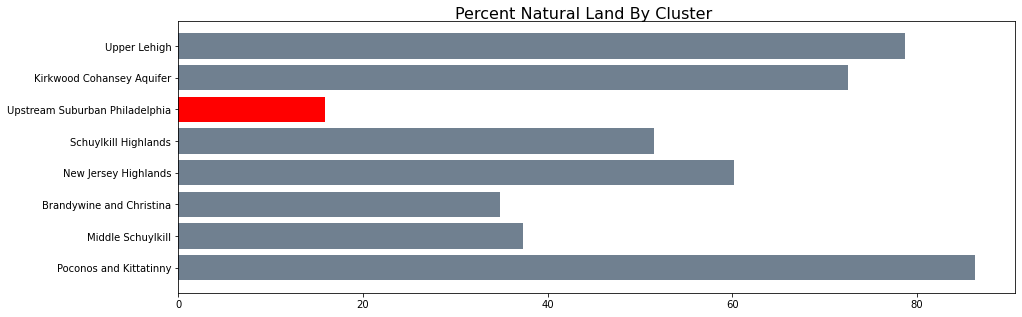

In [30]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
fig.suptitle('Percent Natural Land By Cluster',fontsize=16,y=0.92)

colors = ['red' if i < 30 else 'slategrey' for i in clusterjoin_gdf['perc_natural']]
plt.barh(clusterjoin_gdf['name'], width=clusterjoin_gdf['perc_natural'], color=colors) 
plt.show()

### Focus area by cluster

In [110]:
def plot_natural(sorted_gdf, legend_loc):
    
    natural = plt.barh(sorted_gdf.index, width=sorted_gdf['perc_natural'], color='lightslategrey') 

    # Perc natural protected by WCPA
    # Area in FA computed from geometry and natural lands, WCPA areas, MMW are from what was returned from MMW, so if WCPA MMW runs not complete, this % will potentially inflated
    wcpa_width = sorted_gdf['WCPA_PercNat']
    nonDRWI = plt.barh(sorted_gdf.index, width=wcpa_width, color='gold')

    # Perc natural protected by DRWI
    fd_width = sorted_gdf['FieldDoc_PercNat']
    fd_width = fd_width.fillna(0)
    DRWI = plt.barh(sorted_gdf.index, width=fd_width, color='green', left=wcpa_width)
    
    labels = ["" if x < 0.01 else round(x,1) for x in fd_width]
    ax.bar_label(DRWI, labels, color='white', padding=5, label_type='edge')

    plt.axvline(30, color='red', linestyle=':')
    plt.xlim(0,100)
    plt.xlabel('Percent of Entire FA')
    plt.autoscale(enable=True, axis='y', tight=True)
    
    plt.legend([natural, DRWI, nonDRWI], 
               ['All Natural Land', 'DRWI Protected Natural Land', 'Other Protected Natural Land'],
              loc=legend_loc)

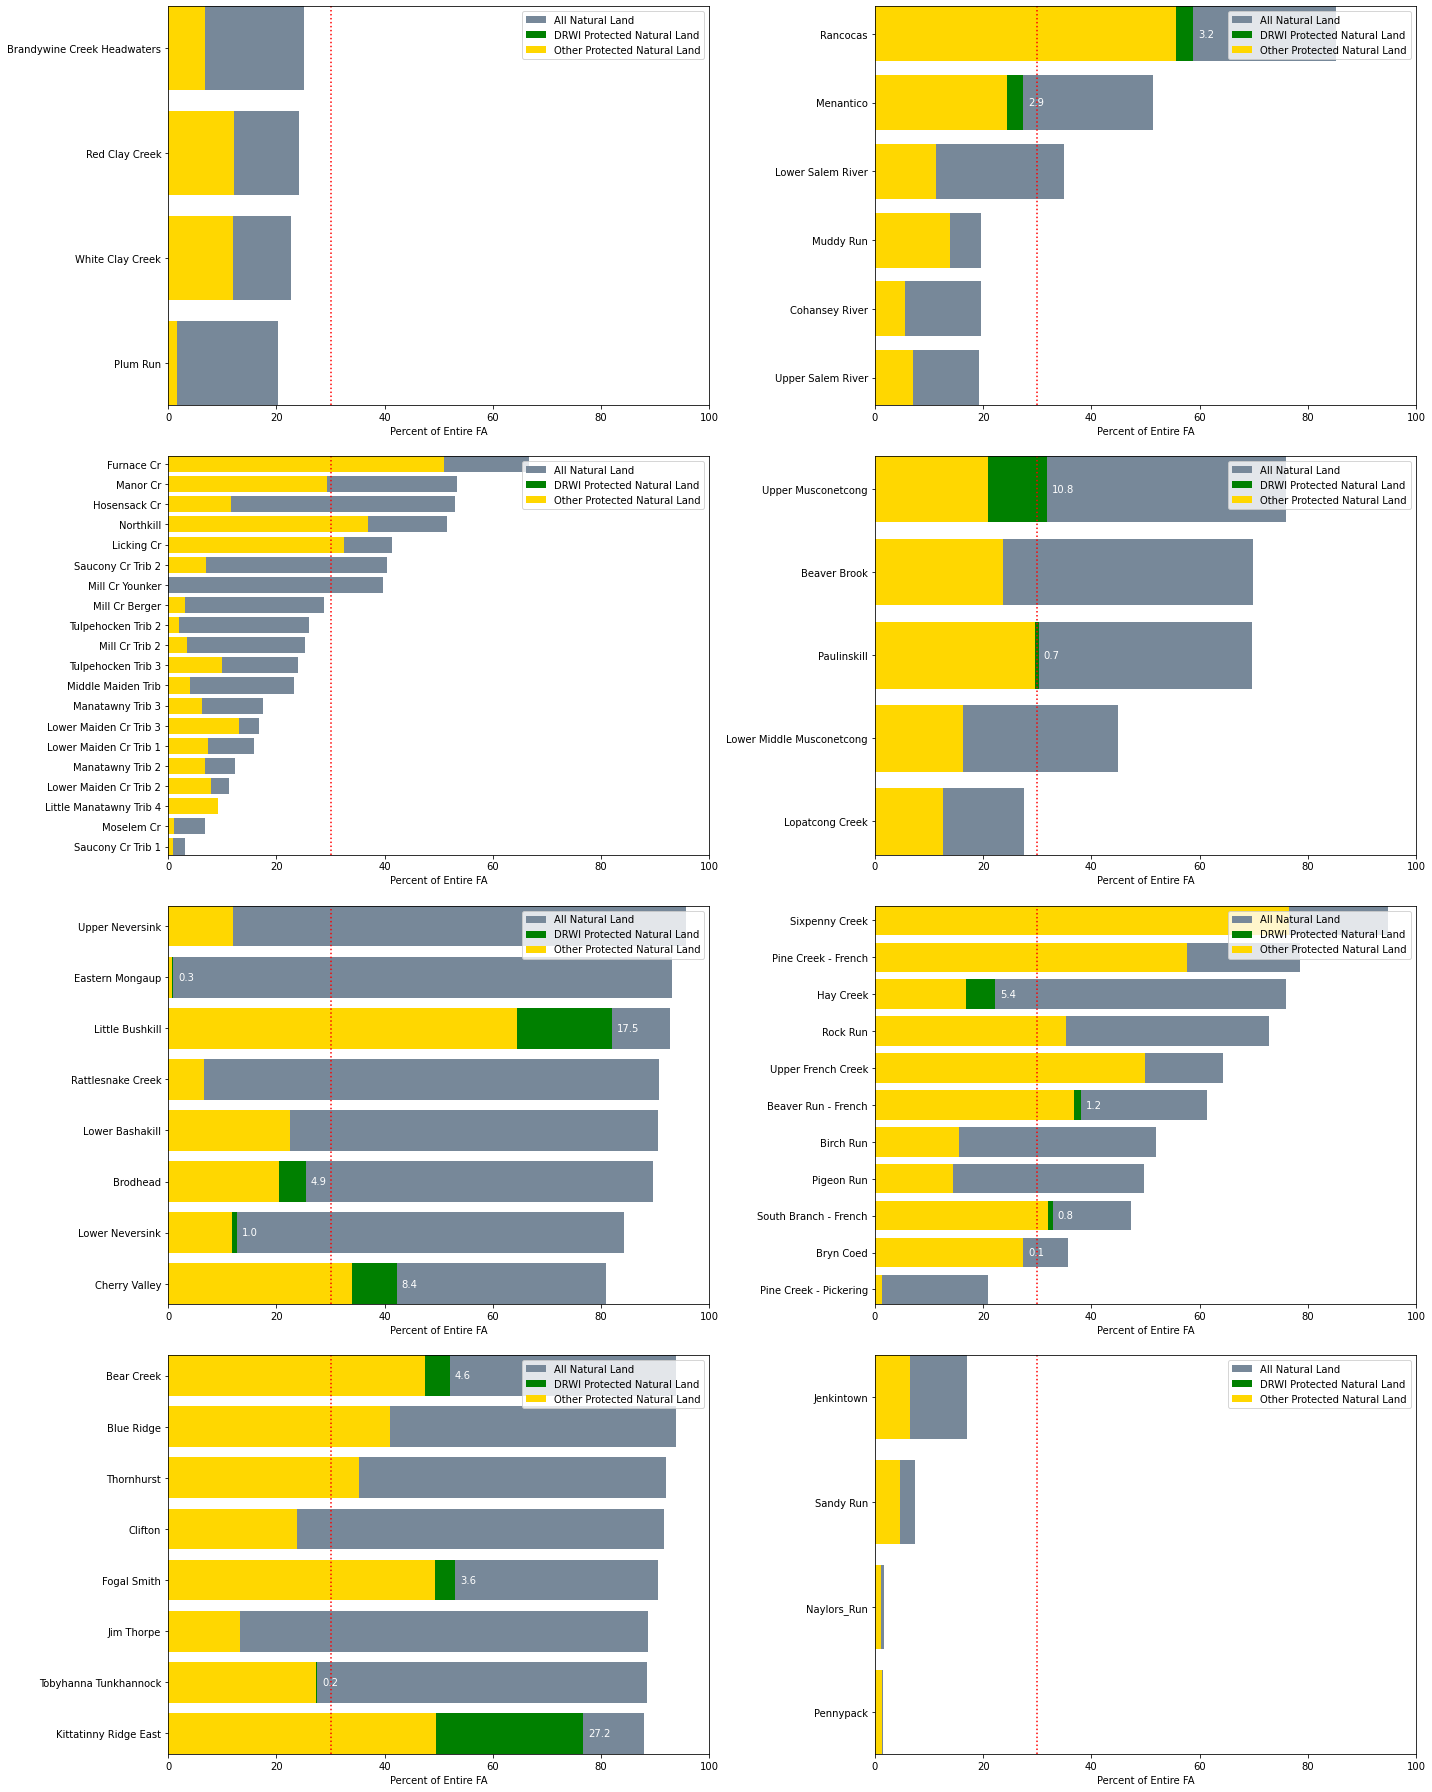

In [113]:
clusters = fajoin_gdf['cluster'].unique()
clusters = clusters.tolist()

fig, ax = plt.subplots(4,2,figsize=(20,25))
n=1

for cluster in clusters:
    sgdf = fajoin_gdf[fajoin_gdf['cluster'] == cluster]
    
    # Plot
    ax = plt.subplot(4,2,n) 
    sorted_sgdf = sgdf.sort_values('perc_natural')
    
    plot_natural(sorted_sgdf,'upper right')
    
    n = n+1


plt.tight_layout(h_pad=2, w_pad=0.75)

plt.show()

### Focus area by grouped by natural land %

In [33]:
high_nat = fajoin_gdf[fajoin_gdf['perc_natural'] > 55].index.to_list()
med_nat = fajoin_gdf[fajoin_gdf['perc_natural'].between(30,55)].index.to_list()
low_nat = fajoin_gdf[fajoin_gdf['perc_natural'] < 30].index.to_list()
nat_level = [high_nat, med_nat, low_nat]

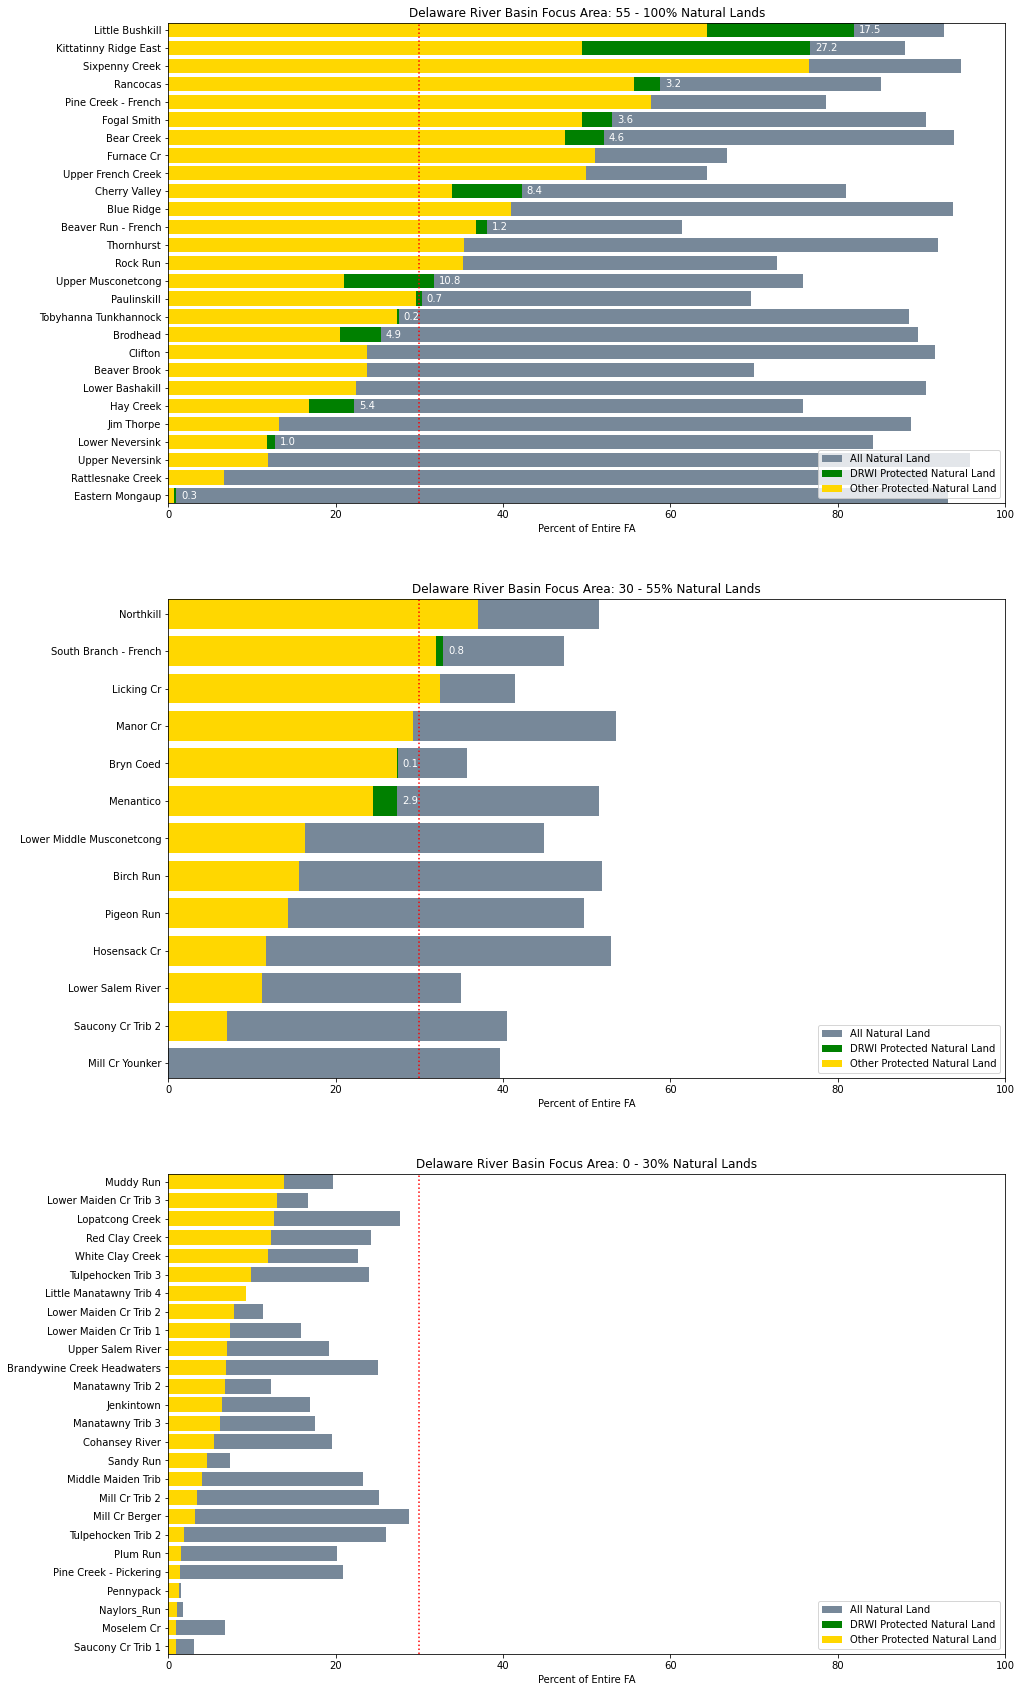

In [114]:
# Plot
fig, ax = plt.subplots(3,1, figsize=(15,30))

fajoin_gdf['all_protected_nat'] = fajoin_gdf['WCPA_PercNat'] + fajoin_gdf['FieldDoc_PercNat']
n=1

for i in nat_level:
    ax = plt.subplot(3,1,n)
    n=n+1

    sub_fajoin_gdf = fajoin_gdf[fajoin_gdf.index.isin(i)]
    
    sorted_sgdf = sub_fajoin_gdf.sort_values('all_protected_nat')

    plot_natural(sorted_sgdf, 'lower right')
    
    if i == high_nat:
        title = '55 - 100% Natural Lands'
    if i == med_nat:
        title = '30 - 55% Natural Lands'
    if i == low_nat:
        title = '0 - 30% Natural Lands'
        
    plt.title(f'Delaware River Basin Focus Area: {title}')

plt.show()


## Maps

### Clusters

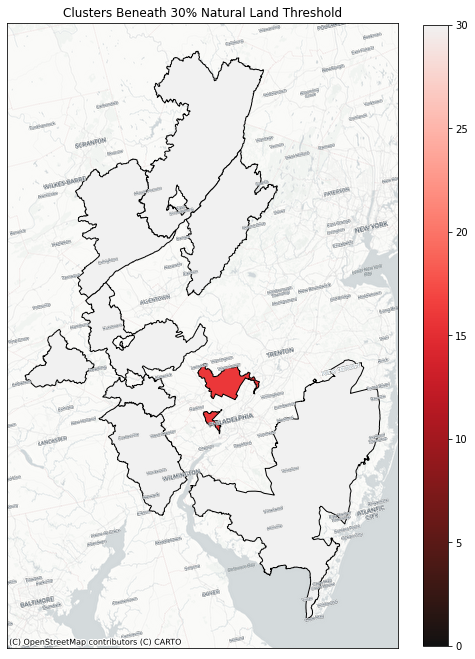

In [35]:
fig, ax1 = plt.subplots(figsize=(7,15))
plt.title('Clusters Beneath 30% Natural Land Threshold')
    
# Add streamreaches to plot
#reach_gdf = reach_gdf.to_crs(pl_gdf.crs.to_string())
#major_streams = reach_gdf[reach_gdf['streamorder'] >= 3].loc[:,('streamorder', 'geom')] 
#rch = major_streams.plot(linewidth=(major_streams['streamorder'] - 1) / 2 , ax=ax1, color='cornflowerblue')

lon_max, lon_min, lat_max, lat_min, area, h_v = LatLonExtent_FA(list(clusterjoin_gdf.index), clusterjoin_gdf)

min_nl = 0
max_nl = 30

# normalize around target with MidPointLogNorm
norm = matplotlib.colors.Normalize(vmin=min_nl, vmax=max_nl)

# Add protected lands to plot
clusterjoin_gdf.plot(column='perc_natural',ax=ax1, cmap='cet_CET_CBTL4', norm=norm, edgecolor='black')

# Turn off ticks
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

# Add colorbar
cax = fig.add_axes([0.95, 0.215, 0.05, 0.575])
sm = plt.cm.ScalarMappable(cmap='cet_CET_CBTL4', 
                           norm=norm)
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=10)
cbr.ax.minorticks_off()


# Add basemap to plot
if area < 7:
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=clusterjoin_gdf.crs.to_string(), zoom=10, interpolation='sinc')
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=clusterjoin_gdf.crs.to_string(), zoom=10, zorder=2, interpolation='sinc')
else:
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=clusterjoin_gdf.crs.to_string(), zoom=9, interpolation='sinc')
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=clusterjoin_gdf.crs.to_string(), zoom=9, zorder=2, interpolation='sinc')


### HUC

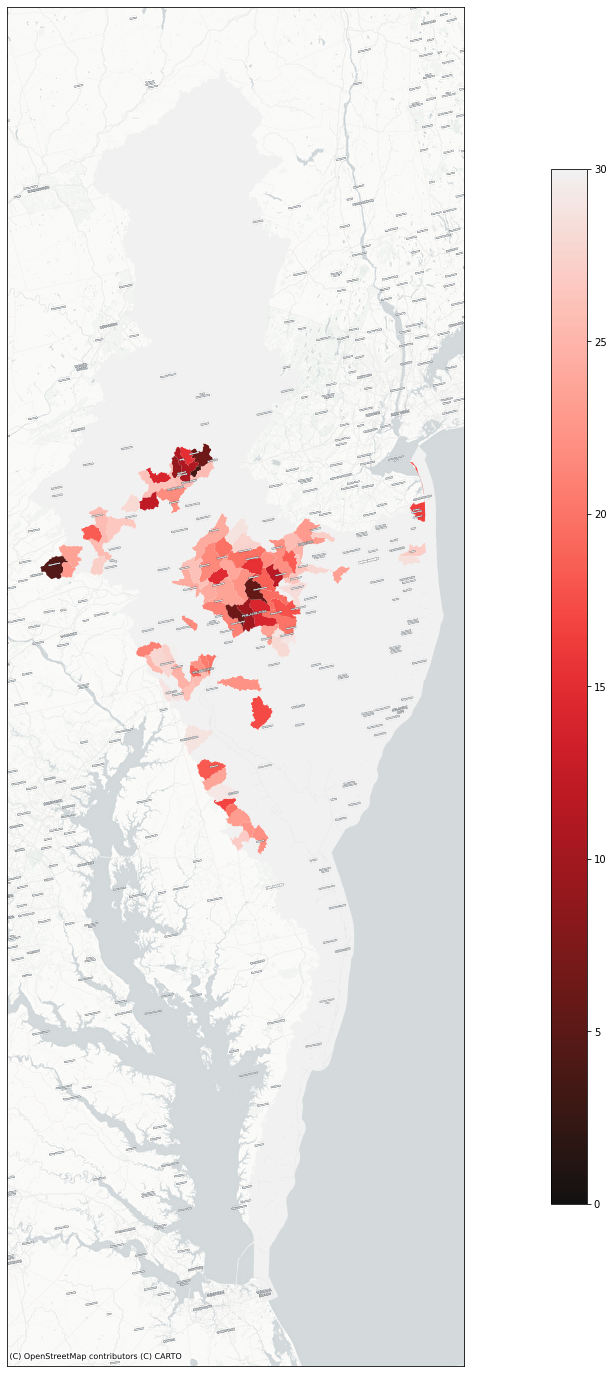

In [115]:
fig, ax1 = plt.subplots(figsize=(10,25))
#plt.title('Clusters Beneath 30% Natural Land Threshold')
    
lon_max, lon_min, lat_max, lat_min, area, h_v = LatLonExtent_FA(list(huc12_gdf.index), huc12_gdf)

min_nl = 0
max_nl = 30

# normalize around target with MidPointLogNorm
norm = matplotlib.colors.Normalize(vmin=min_nl, vmax=max_nl)

# Add protected lands to plot
huc12join_gdf.plot(column='perc_natural',ax=ax1, cmap='cet_CET_CBTL4', norm=norm)

# Turn off ticks
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

# Add colorbar
cax = fig.add_axes([0.95, 0.215, 0.05, 0.575])
sm = plt.cm.ScalarMappable(cmap='cet_CET_CBTL4',
                           norm=norm)
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=10)
cbr.ax.minorticks_off()


# Add basemap to plot
if area < 7:
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=clusterjoin_gdf.crs.to_string(), zoom=10, interpolation='sinc')
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=clusterjoin_gdf.crs.to_string(), zoom=10, zorder=2, interpolation='sinc')
else:
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=clusterjoin_gdf.crs.to_string(), zoom=9, interpolation='sinc')
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=clusterjoin_gdf.crs.to_string(), zoom=9, zorder=2, interpolation='sinc')